# BDA3 - Spark

Submission by:

- Julius Kittler (julki092)
- Maximilian Pfundstein (maxpf364)

***

# Implementation

It seems like the 00:00:00 measurements belong to the "next day" and are hence always at the beginning of a day (not at the end of a day). Hence, we do not filter otu 00:00:00 from a certain day if we want to make a prediction for 00:00:00 for this day since the 00:00:00 measurement would basically be for the previous day. In other words, for the 00:00:00 predictions, we keep all measurements with timestamp 23:59:59 and smaller for the prediction.

In [18]:
from __future__ import division
from math import radians, cos, sin, asin, sqrt, exp
import datetime as dt
from pyspark import SparkContext
from operator import add
import time as timer

start_time = timer.time()

# -----------------------------------------------------------------
# Function definitions
# -----------------------------------------------------------------

def haversine(lonlat1, lon2, lat2):
    
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1 = lonlat1[0]
    lat1 = lonlat1[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    dist_km = 6367 * c
    return(dist_km)


def daydiff(date1, date2):
    
    """
    Calculate the difference in days. It's assumed that this difference
    is to be computed relative to the day in the year. E.g. if we have the
    days "1950-01-01" and "2013-01-01", the difference is 0 and if we have
    the days "1950-12-01" and "2013-01-01, the difference is 31.
    """

    # Compute difference in days
    dist_days = abs((date1 - date2).days) % 365

    if dist_days > 365/2:
        dist_days = 365 - dist_days

    return(dist_days)
    

def hourdiff(time1, time2):
    
    """
    Calculate the difference in hours. It's assumed that this difference
    is to be computed relative to the day. E.g. if we have the hours
    "23:00" and "01:00", the difference is 2 hours and if we have the 
    hours "23:00" and "14:00", the difference is 9 hours.
    """

    # Compute difference in hours
    dist_hours = abs(time1 - time2) % 24

    if dist_hours > 24/2:
        dist_hours = 24 - dist_hours

    return(dist_hours)

def gaussian_kernel(dist, h):
    return(exp(-(dist/h)**2))
    
    
# -----------------------------------------------------------------
# Parameter Preparation
# -----------------------------------------------------------------
    
h_distance = 150 # Up to you
h_date = 30 # Up to you
h_time = 3 # Up to you

# Test case
lon = 58.4166 # Up to you
lat = 15.6333 # Up to you
date = "2000-05-08" # Up to you

# -----------------------------------------------------------------
# Execution
# -----------------------------------------------------------------

sc = SparkContext(appName = "BDA")

# Import data and save relevant variables to RDDs
print("Import data and save relevant variables to RDD...")

# stat = sc.textFile("/user/x_julki/data/stations.csv").map(lambda l: l.split(";"))
# temp = sc.textFile("/user/x_julki/data/temperature-readings.csv").map(lambda l: l.split(";"))
temp = sc.textFile("input/temperature-readings.csv").map(lambda l: l.split(";"))
stat = sc.textFile("input/stations.csv").map(lambda l: l.split(";"))

# ((station, date, time), temp)
temp = temp.map(lambda l: ((int(l[0]), # station
                           dt.datetime.strptime(str(l[1]), '%Y-%m-%d').date(), # date
                           int(l[2][0:2])), # time
                           float(l[3]))) # temp
# (station, (lat, lon))
stat = stat.map(lambda l: (int(l[0]), (float(l[3]), float(l[4]))))


# Broadcast the station RDD
print("Broadcast the station RDD...")
stat = stat.collectAsMap()
stat = sc.broadcast(stat)

# Filter temp to s.t. it only contains dates before and including specified date
print("Filter temp to s.t. it only contains dates before and including specified date...")
date = dt.datetime.strptime(date, '%Y-%m-%d').date()
temp = temp.filter(lambda l: l[0][1] <= date)


# Do prediction for 00:00:00 based on all values
print("Start predictions...")
times = [0] + [hr for hr in range(22, 2, -2)]
temp = temp.map(lambda l: (l[0], (l[1], 
                                  float(gaussian_kernel(haversine(stat.value[l[0][0]], lon, lat), h_distance)), # kern_distance
                                  float(gaussian_kernel(daydiff(l[0][1], date), h_date)), # kern_date
                                  float(gaussian_kernel(hourdiff(l[0][2], times[0]), h_time)))))#.cache() # kern_time
pred = temp.map(lambda l: (l[1][1] + l[1][2] + l[1][3], l[1][0] * (l[1][1] + l[1][2] + l[1][3])))
# pred = pred.coalesce(1).reduce(lambda x, y: (x[0] + y[0], x[1] +  y[1]))
print("Start reduction...")
pred = pred.reduce(lambda x, y: (x[0] + y[0], x[1] +  y[1]))
print("End reduction...")
pred = round(pred[1]/pred[0], 4)
print("### Predictions: {} |lon {} | lat {} ###\n\n{}: {}".format(date, lon, lat, times[0], pred))
preds = [pred]

# Do prediction for 22:00:00, 20:00:00, ..., 04:00:00
for time in times[1:]:
    
    # Drop time for the time to predict and all times afterwards
    temp = temp.filter(lambda l: not (l[0][1] == date and l[0][2] >= time))#.cache()
    
    pred = temp.map(lambda l: (l[0], (l[1][0], l[1][1], l[1][2], # keep temp, kern_distance, kern_date from previous computation
                                      float(gaussian_kernel(hourdiff(l[0][2], time), h_time))))) # kern_time is computed newly
    pred = pred.map(lambda l: (l[1][1] + l[1][2] + l[1][3], l[1][0] * (l[1][1] + l[1][2] + l[1][3])))
    pred = pred.coalesce(1).reduce(lambda x, y: (x[0] + y[0], x[1] +  y[1]))
    pred = round(pred[1]/pred[0], 4)
    print("{}: {}".format(time, pred))
    preds += [pred]

res = sc.parallelize(((time, pred) for time, pred in zip(times, preds))).coalesce(1).saveAsTextFile("BDA3_results/temperature-predictions.txt")

sc.stop()

print("\n--- %s minutes ---" % ((timer.time() - start_time)/60))

Import data and save relevant variables to RDD...
Broadcast the station RDD...
Filter temp to s.t. it only contains dates before and including specified date...
Start predictions...
Start reduction...
End reduction...
### Predictions: 2000-05-08 |lon 58.4166 | lat 15.6333 ###

0: 5.4756
22: 5.7105
20: 5.8828
18: 6.0619
16: 6.4134
14: 6.7195
12: 6.7143
10: 6.3807
8: 5.7063
6: 5.1673
4: 5.0921

--- 355.3775406519572 minutes ---


# Question 1 (TODO)

# Question 1 (TODO)

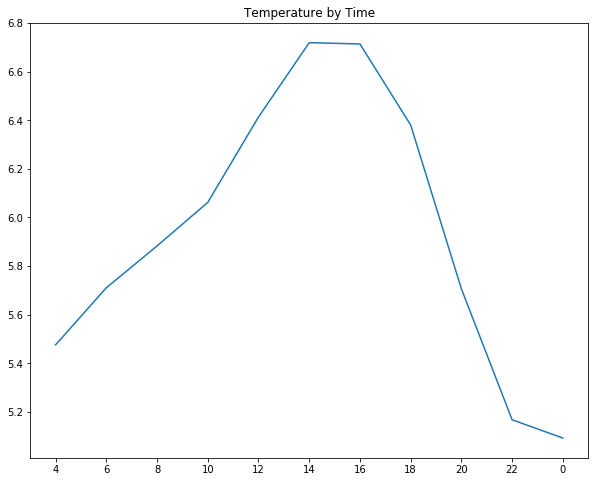

In [20]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0)
times = [dt.datetime.strptime('00:00:00', '%H:%M:%S').time()] + [dt.time(hr, 0) for hr in range(22, 2, -2)]
times = [str(time.hour) for time in times][::-1]
plt.title("Temperature by Time")
plt.plot(times, preds)
plt.show()